In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn import preprocessing
import seaborn as sns
from sklearn.decomposition import PCA 

import matplotlib.pyplot as plt

from scipy import sparse
from scipy.cluster.hierarchy import cophenet, fcluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

# Z = linkage(x_reduced, method='ward')

## EDA for Milestone 4

In [7]:
df_original = pd.read_csv('../../sample_data_2017_M4_cleaned.csv')

In [2]:
# df_original = pd.read_csv('../sample_data_2017_M4.csv')

# ## if more than one filing per org, take the most recent
# df_multiple = pd.DataFrame(df_original.groupby('EIN').max()['TaxPeriod'])
# df_multiple = df_multiple.reset_index()
# df_original = df_multiple.merge(df_original, on = ['EIN', 'TaxPeriod'], how = 'left')

# df_original = df_original.drop(['ActivityOrMissionDesc'
#               , 'BooksInCareOfDetail/USAddress/ZIPCode'
#               , 'Desc'
#               , 'MissionDesc'
#               , 'OrganizationName'
#               , 'URL'
#               , 'WebsiteAddressTxt'
#               , '_id'
# #               , 'FormType'
#               , 'TaxExemptBondsInd'
#               , 'TaxPeriod'
#               , 'EmployeeCnt' #dupe
#               , 'NetAssetsOrFundBalancesEOYAmt' #dupe
#              ], axis =1)

# df_original.to_csv('./sample_data_2017_M4_cleaned.csv', index=False)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (6,9,12,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df_original['FormType'] = [str(x) for x in df_original['FormType']]
df_original['FormType'].unique()

array(['990', '990EZ'], dtype=object)

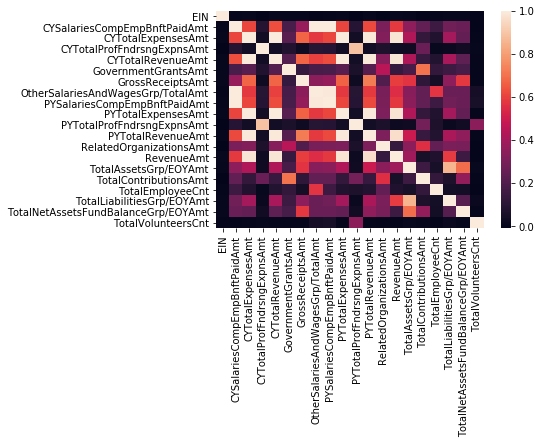

In [6]:
## correlation matrix
## unsurprisingly, revenue-related fields are correlated, as are salary fields, net assets, etc.
corr = df_original.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [9]:
df_990 = df_original[df_original['FormType'] == '990']
df_990EZ = df_original[df_original['FormType'] == '990EZ']
df_990 = df_990.drop(['FormType'], axis = 1)
df_990EZ = df_990EZ.drop(['FormType'], axis = 1)
df_990EZ = df_990EZ.dropna(how = "all", axis = 1)
df_990.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64213 entries, 0 to 106850
Data columns (total 20 columns):
EIN                                    64213 non-null int64
CYSalariesCompEmpBnftPaidAmt           64213 non-null float64
CYTotalExpensesAmt                     64213 non-null float64
CYTotalProfFndrsngExpnsAmt             64213 non-null float64
CYTotalRevenueAmt                      64213 non-null float64
GovernmentGrantsAmt                    15795 non-null float64
GrossReceiptsAmt                       64213 non-null float64
OtherSalariesAndWagesGrp/TotalAmt      45578 non-null float64
PYSalariesCompEmpBnftPaidAmt           52079 non-null float64
PYTotalExpensesAmt                     62310 non-null float64
PYTotalProfFndrsngExpnsAmt             30393 non-null float64
PYTotalRevenueAmt                      62438 non-null float64
RelatedOrganizationsAmt                3856 non-null float64
RevenueAmt                             31481 non-null float64
TotalAssetsGrp/EOYAmt    

In [180]:
df_990EZ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43143 entries, 64529 to 107671
Data columns (total 5 columns):
EIN                                    43143 non-null int64
GrossReceiptsAmt                       42486 non-null float64
RevenueAmt                             42633 non-null float64
TotalAssetsGrp/EOYAmt                  43143 non-null int64
TotalNetAssetsFundBalanceGrp/EOYAmt    43143 non-null int64
dtypes: float64(2), int64(3)
memory usage: 2.0 MB


In [181]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107672 entries, 0 to 107671
Data columns (total 21 columns):
CYSalariesCompEmpBnftPaidAmt           64529 non-null float64
CYTotalExpensesAmt                     64529 non-null float64
CYTotalProfFndrsngExpnsAmt             64529 non-null float64
CYTotalRevenueAmt                      64529 non-null float64
EIN                                    107672 non-null int64
FormType                               107672 non-null object
GovernmentGrantsAmt                    15858 non-null float64
GrossReceiptsAmt                       107015 non-null float64
OtherSalariesAndWagesGrp/TotalAmt      45769 non-null float64
PYSalariesCompEmpBnftPaidAmt           52300 non-null float64
PYTotalExpensesAmt                     62592 non-null float64
PYTotalProfFndrsngExpnsAmt             30504 non-null float64
PYTotalRevenueAmt                      62722 non-null float64
RelatedOrganizationsAmt                3878 non-null float64
RevenueAmt            

### Decide how we want to handle missing data.
### Zero-fill the "rare" fields and mean-fill the rest. Do separately for 990s and EZs.

In [10]:
## Possibly safe to assume if they didn't file it, it doesn't exist (i.e. $0)
df_990EZ = df_990EZ.fillna(0)
# df_990EZ['GrossReceiptsAmt'] = df_990EZ['GrossReceiptsAmt'].fillna(df_990EZ['GrossReceiptsAmt'].mean())
# df_990EZ['RevenueAmt'] = df_990EZ['RevenueAmt'].fillna(df_990EZ['RevenueAmt'].mean())

df_990 = df_990.fillna(0)

In [11]:
def standardize(df):
    eins = list(df['EIN'])
#     df = df.fillna(0)
    cols = df.loc[:, df.columns != 'EIN'].columns
    df = pd.DataFrame(preprocessing.scale(df.loc[:, df.columns != 'EIN']))
    df.columns = cols
    df['EIN'] = eins
    return df

In [12]:
def PCA_components(df):
    pca = PCA()
    pca.fit(df.loc[:, df.columns != 'EIN'])
    df_pca = pca.transform(df.loc[:, df.columns != 'EIN'])
    var = pca.explained_variance_ratio_
    var_cumsum = np.cumsum(var)
    comp = range(1, len(var)+1)

    %matplotlib inline
    plt.plot(comp,var_cumsum)
    plt.xlabel('Components')
    plt.ylabel('% Variance')
    plt.title('Variance explained by each component')
    print(var_cumsum)

In [13]:
def fit_pca(df, n):
    eins = list(df['EIN'])
    pca = PCA(n_components = n)
    pca.fit(df.loc[:, df.columns != 'EIN'])
    df_pca = pca.transform(df.loc[:, df.columns != 'EIN'])
    df_pca = pd.DataFrame(df_pca)
    df_pca['EIN'] = eins
    return df_pca

In [14]:
def plot_elbow(df, k_max=50):
    distortions = []
    K = range(1, k_max)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, init = 'k-means++', random_state = 0).fit(df.loc[:, df.columns != 'EIN'])
        distortions.append(sum(np.min(cdist(df.loc[:, df.columns != 'EIN'], kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.loc[:, df.columns != 'EIN'].shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'x')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.show()

In [15]:
def fit_kmeans(df, n):
    model = KMeans(n_clusters = n, init = 'k-means++', random_state = 0).fit(df.loc[:, df.columns != 'EIN'])
    return model

### Results from 20 clusters, both form types combined

In [61]:
df_pca['k20_labels'] = k20.labels_
df_pca.groupby('k20_labels').count()

,0,1,2,3,4,5,6,7,EIN
k20_labels,,,,,,,,,
0,106757,106757,106757,106757,106757,106757,106757,106757,106757
1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1
5,13,13,13,13,13,13,13,13,13
6,30,30,30,30,30,30,30,30,30
7,1,1,1,1,1,1,1,1,1
8,9,9,9,9,9,9,9,9,9


### Split data into groups based on EmployeeCnt and model separately

In [92]:
for p in [0.25, 0.5, 0.75, 0.9]:
    print(str(p) + '%: ' + str(df_original[df_original['EmployeeCnt'] != 0]['EmployeeCnt'].quantile(p)))

0.25%: 4.0
0.5%: 12.0
0.75%: 43.0
0.9%: 166.0


In [113]:
df0 = df_original[df_original['EmployeeCnt'].isna()].append(df_original[df_original['EmployeeCnt'] == 0])
df1 = df_original[df_original['EmployeeCnt'] > 0]
df1 = df1[df1['EmployeeCnt'] < 50]
df2 = df_original[df_original['EmployeeCnt'] >= 50]

In [114]:
print(len(df_original) == len(df0) + len(df1) + len(df2))
print(len(df0), len(df1), len(df2))

True
68954 29964 8754


In [115]:
df0 = standardize(df0)
df1 = standardize(df1)
df2 = standardize(df2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


[0.37467735 0.49505902 0.60857626 0.70396073 0.78715009 0.84773429
 0.90455839 0.94214539 0.96522328 0.98047395 0.99450389 0.99848268
 0.99961373 0.99982395 0.99990429 0.99994913 0.99998735 1.
 1.         1.         1.        ]


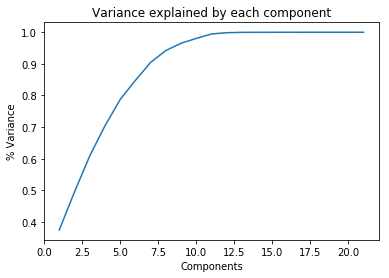

In [119]:
# PCA_components(df0) # 9 components
# PCA_components(df1) # 11 components
PCA_components(df2) # 9 components

In [122]:
df00 = fit_pca(df0, 9)
df11 = fit_pca(df1, 11)
df22 = fit_pca(df2, 9)

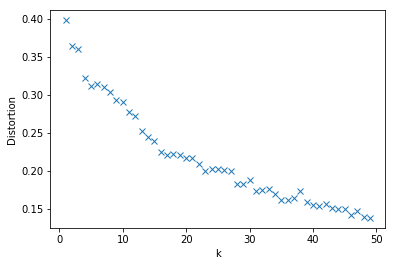

In [127]:
plot_elbow(df00)

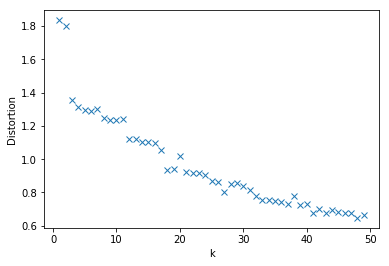

In [128]:
plot_elbow(df11)

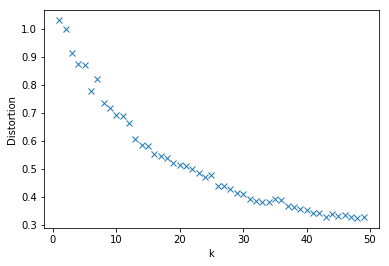

In [129]:
plot_elbow(df22)

In [144]:
model = fit_kmeans(df00, 30)
df00['labels'] = model.labels_
df00.groupby('labels').count()['EIN']

labels
0     67553
1       891
2         1
3         2
4         1
5         1
6         1
7        17
8         1
9         6
10        1
11        1
12        3
13        4
14       16
15       13
16       24
17        5
18      188
19       55
20        1
21       11
22       20
23        1
24       20
25      107
26        1
27        1
28        5
29        3
Name: EIN, dtype: int64

In [138]:
model = fit_kmeans(df11, 20)
df11['labels'] = model.labels_
df11.groupby('labels').count()['EIN']

labels
0      1491
1     13220
2      3249
3      7355
4         2
5      1949
6      2185
7         3
8         1
9        17
10        1
11       12
12       64
13       56
14      305
15        2
16        3
17        3
18        7
19       39
Name: EIN, dtype: int64

In [139]:
model = fit_kmeans(df22, 30)
df22['labels'] = model.labels_
df22.groupby('labels').count()['EIN']

labels
0     7397
1      417
2        1
3       40
4        1
5      394
6        1
7        4
8        1
9        1
10       5
11       4
12       7
13       1
14     132
15      33
16      79
17       3
18       1
19      54
20      95
21       6
22      25
23       1
24       1
25      11
26       1
27       8
28       6
29      24
Name: EIN, dtype: int64

### Split data based on TotalAssetsGrp/EOYAmt

In [149]:
for p in [0.25, 0.5, 0.75, 0.9]:
    print(str(p) + '%: ' + str(df_original[df_original['TotalAssetsGrp/EOYAmt'] != 0]['TotalAssetsGrp/EOYAmt'].quantile(p)))

0.25%: 48984.75
0.5%: 213382.0
0.75%: 1185674.0
0.9%: 6419648.0


(array([1.07657e+05, 1.10000e+01, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-1.98639130e+07,  7.99319123e+09,  1.60062464e+10,  2.40193015e+10,
         3.20323566e+10,  4.00454118e+10,  4.80584669e+10,  5.60715221e+10,
         6.40845772e+10,  7.20976323e+10,  8.01106875e+10]),
 <a list of 10 Patch objects>)

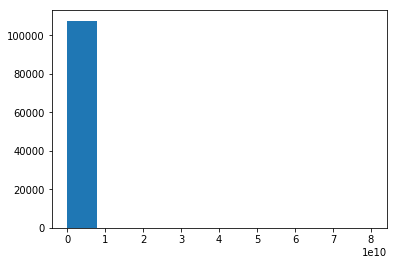

In [163]:
plt.hist(df_original['TotalAssetsGrp/EOYAmt'])

In [169]:
df0 = df_original[df_original['TotalAssetsGrp/EOYAmt'] < 50000]
df1 = df_original[df_original['TotalAssetsGrp/EOYAmt'] >= 50000]
df1 = df1[df1['TotalAssetsGrp/EOYAmt'] < 1000000]
df2 = df_original[df_original['TotalAssetsGrp/EOYAmt'] >= 1000000]

In [170]:
print(len(df_original) == len(df0) + len(df1) + len(df2))
print(len(df0), len(df1), len(df2))

True
28873 50198 28601


In [171]:
df0 = standardize(df0)
df1 = standardize(df1)
df2 = standardize(df2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


[0.42117397 0.54591463 0.66238029 0.75741731 0.82548974 0.88715386
 0.92809236 0.95461694 0.97009446 0.98447884 0.99419154 0.9982434
 0.99955996 0.99977344 0.99987758 0.9999306  0.99997927 0.99999839
 1.         1.         1.        ]


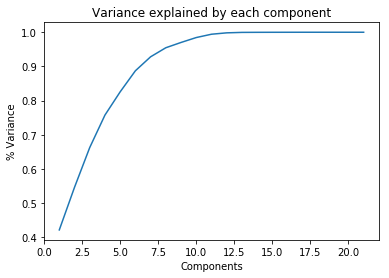

In [174]:
# PCA_components(df0) # 10 components
# PCA_components(df1) # 11 components
PCA_components(df2) # 8 components

In [175]:
df00 = fit_pca(df0, 10)
df11 = fit_pca(df1, 11)
df22 = fit_pca(df2, 8)

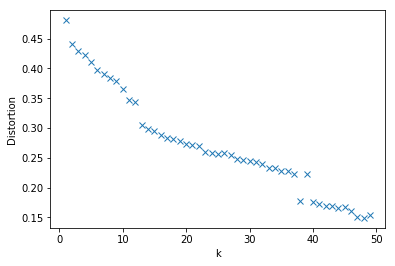

In [176]:
plot_elbow(df00)

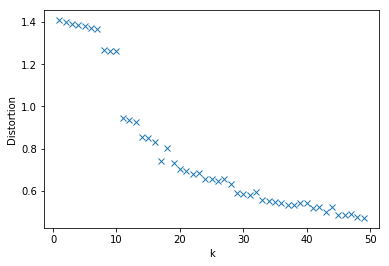

In [177]:
plot_elbow(df11)

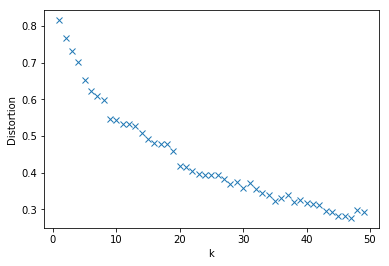

In [178]:
plot_elbow(df22)

In [182]:
model = fit_kmeans(df00, 12)
df00['labels'] = model.labels_
df00.groupby('labels').count()['EIN']

labels
0     12610
1     15957
2         5
3       279
4         1
5         6
6         3
7         1
8         8
9         1
10        1
11        1
Name: EIN, dtype: int64

In [184]:
model = fit_kmeans(df11, 20)
df11['labels'] = model.labels_
df11.groupby('labels').count()['EIN']

labels
0     10389
1     22902
2       326
3         1
4         2
5      6265
6         1
7         5
8         1
9         1
10     3702
11        1
12        2
13     1105
14        2
15        1
16       13
17      871
18     4583
19       25
Name: EIN, dtype: int64

In [186]:
model = fit_kmeans(df22, 20)
df22['labels'] = model.labels_
df22.groupby('labels').count()['EIN']

labels
0     26964
1      1209
2         1
3         3
4         1
5         1
6        56
7         1
8         4
9         6
10        1
11        1
12        8
13       11
14       17
15      245
16        5
17       10
18       40
19       17
Name: EIN, dtype: int64

### Model 990s and EZs separately

In [16]:
df_990 = standardize(df_990)
df_990EZ = standardize(df_990EZ)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


[0.40058496 0.51926458 0.61365641 0.70143015 0.76638549 0.81904086
 0.86946493 0.91611293 0.96004241 0.97781452 0.99204705 0.99803542
 0.99949781 0.99974527 0.99986383 0.99992365 0.99997835 1.
 1.        ]


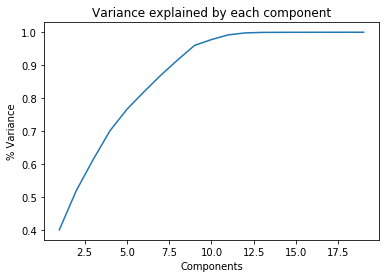

In [38]:
PCA_components(df_990) # 8 components

[0.54905956 0.88357642 0.97948896 1.        ]


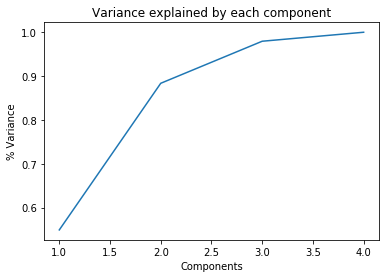

In [37]:
PCA_components(df_990EZ) # no PCA

In [39]:
df_990_pca = fit_pca(df_990, 8)

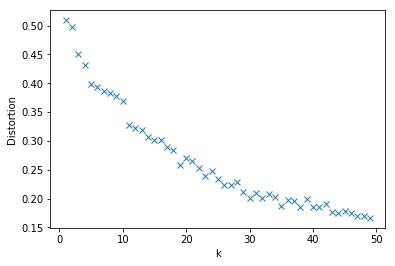

In [40]:
plot_elbow(df_990_pca)

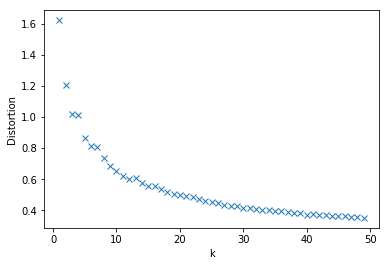

In [41]:
plot_elbow(df_990EZ)

In [42]:
model = fit_kmeans(df_990_pca, 30)
df_990_pca['labels'] = model.labels_
df_990_pca.groupby('labels').count()['EIN']

labels
0     61331
1         1
2        11
3         4
4         7
5         1
6         1
7         1
8         1
9        78
10        3
11       40
12        1
13       12
14        8
15      268
16       50
17       33
18       28
19      174
20        5
21        8
22      300
23        1
24        1
25     2049
26        4
27        3
28        3
29      102
Name: EIN, dtype: int64

In [17]:
model = fit_kmeans(df_990EZ, 20)
df_990EZ['labels'] = model.labels_
df_990EZ.groupby('labels').count()['EIN']

labels
0     2908
1     2079
2      992
3     1345
4     1036
5        4
6     2234
7     4444
8     1413
9     1266
10      79
11       2
12    6286
13    2193
14     762
15    6551
16      16
17    2917
18     205
19    5906
Name: EIN, dtype: int64

In [19]:
df_990EZ.to_csv('./sample_data_2017_M4_990EZ_labels.csv', index=False)

In [63]:
df_990EZ_pca = fit_pca(df_990EZ.loc[:, df_990EZ.columns != 'labels'], 2)
df_990EZ_pca['labels'] = model.labels_
df_990EZ_pca.head()

,0,1,EIN,labels
0,1.026432,-0.051638,42662873,7
1,1.228644,-0.297288,42964630,0
2,-0.164392,-0.753209,382912028,11
3,-0.461376,0.064330,200509226,2
4,1.476135,0.086446,202699020,0


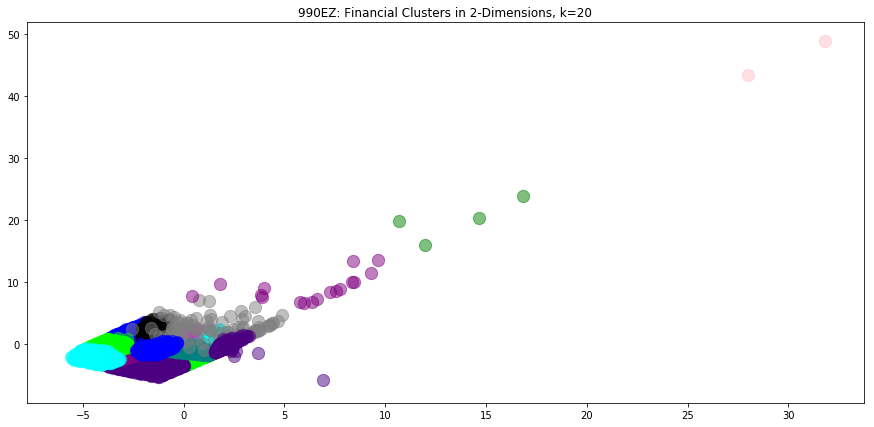

In [65]:
plt.figure(figsize=(15,7))
# colors = ['cyan', 'orange', 'red', 'teal', 'black', 'pink', 'purple', 'blue', 'grey', 'green'
#          ,'lime', 'yellow', 'magenta', 'indigo', 'red', 'red', 'red', 'red', 'red', 'red']
colors = ['red', 'orange', 'yellow', 'green', 'lime', 'blue', 'indigo', 'cyan', 'purple', 'magenta', 'pink',
         'teal', 'black', 'grey', 'green', 'lime', 'blue', 'indigo', 'cyan', 'purple', 'magenta']
for label in range(20):
    df_sample = df_990EZ_pca[df_990EZ_pca['labels'] == label]
    x = plt.scatter(df_sample[0], df_sample[1], c = colors[label], alpha = .5, s = 150)
#     plt.legend([x], colors[label])
#     legend = plt.legend(handles=[x])
#     ax = plt.gca().add_artist(legend)
plt.title("990EZ: Financial Clusters in 2-Dimensions, k=20")
plt.show()

### 990EZs in good-ish shape. Split 990s by employee count.

In [208]:
df_990 = df_990.merge(df_original[['EIN', 'TotalEmployeeCnt']], on = 'EIN', how = 'left') # don't want this standardized

In [210]:
for p in [0.25, 0.5, 0.75, 0.9]:
    print(str(p) + '%: ' + str(df_990['TotalEmployeeCnt_x'].quantile(p)))

0.25%: -0.023702303365479346
0.5%: -0.022878312942629563
0.75%: -0.01875836082838065
0.9%: -0.0017292254228184702


In [211]:
for p in [0.25, 0.5, 0.75, 0.9]:
    print(str(p) + '%: ' + str(df_990['TotalEmployeeCnt_y'].quantile(p)))

0.25%: 0.0
0.5%: 3.0
0.75%: 18.0
0.9%: 80.0


In [213]:
df0 = df_990[df_990['TotalEmployeeCnt_y'] == 0]
df1 = df_990[df_990['TotalEmployeeCnt_y'] > 0]
df1 = df1[df1['TotalEmployeeCnt_y'] < 20]
df2 = df_990[df_990['TotalEmployeeCnt_y'] >= 20]
df2 = df2[df2['TotalEmployeeCnt_y'] < 80]
df3 = df_990[df_990['TotalEmployeeCnt_y'] >= 80]

In [214]:
print(len(df_990) == len(df0) + len(df1) + len(df2) + len(df3))
print(len(df0), len(df1), len(df2), len(df3))

True
25649 23317 8776 6471


In [218]:
df0 = df0.drop(['TotalEmployeeCnt_y'], axis = 1)
df1 = df1.drop(['TotalEmployeeCnt_y'], axis = 1)
df2 = df2.drop(['TotalEmployeeCnt_y'], axis = 1)
df3 = df3.drop(['TotalEmployeeCnt_y'], axis = 1)
df0 = df0.drop(['TotalEmployeeCnt_x'], axis = 1)
df1 = df1.drop(['TotalEmployeeCnt_x'], axis = 1)
df2 = df2.drop(['TotalEmployeeCnt_x'], axis = 1)
df3 = df3.drop(['TotalEmployeeCnt_x'], axis = 1)

In [260]:
df_990 = df_990.drop(['TotalEmployeeCnt_y'], axis = 1)

[0.48846396 0.61340706 0.72941433 0.80575264 0.86506461 0.92208713
 0.95958507 0.97782733 0.99473283 0.99790118 0.99941938 0.999706
 0.99981373 0.99987975 0.99993242 0.9999832  1.         1.        ]


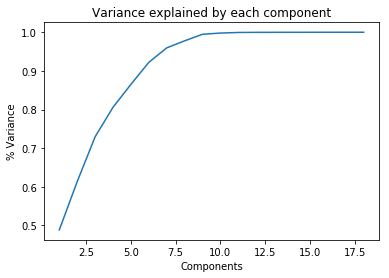

In [224]:
# PCA_components(df0) # 5 components
# PCA_components(df1) # 4 components
# PCA_components(df2) # 4 components
PCA_components(df3) # 7 components

In [226]:
d0_pca = fit_pca(df0, 5)
d1_pca = fit_pca(df1, 4)
d2_pca = fit_pca(df2, 4)
d3_pca = fit_pca(df3, 7)

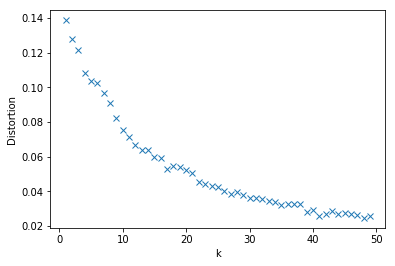

In [227]:
plot_elbow(d0_pca)

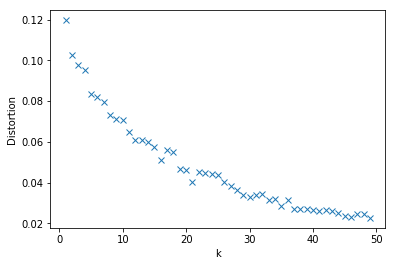

In [228]:
plot_elbow(d1_pca)

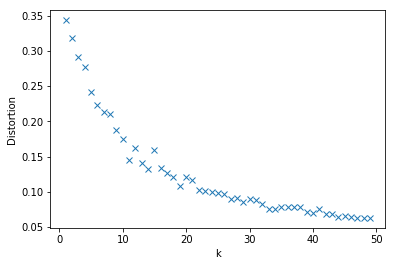

In [229]:
plot_elbow(d2_pca)

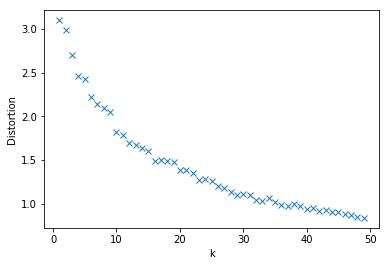

In [230]:
plot_elbow(d3_pca)

In [238]:
model = fit_kmeans(d0_pca, 10)
d0_pca['labels'] = model.labels_
d0_pca.groupby('labels').count()['EIN']

labels
0    10390
1       39
2        0
3      186
4        0
5        2
6      117
7        1
8        0
9        3
Name: EIN, dtype: int64

In [239]:
model = fit_kmeans(d1_pca, 10)
d1_pca['labels'] = model.labels_
d1_pca.groupby('labels').count()['EIN']

labels
0    7184
1     828
2      75
3      73
4       0
5       2
6       0
7     124
8       1
9       4
Name: EIN, dtype: int64

In [240]:
model = fit_kmeans(d2_pca, 10)
d2_pca['labels'] = model.labels_
d2_pca.groupby('labels').count()['EIN']

labels
0    1155
1      20
2       0
3      81
4       0
5       0
6       1
7       2
8       2
9       0
Name: EIN, dtype: int64

In [241]:
model = fit_kmeans(d3_pca, 10)
d3_pca['labels'] = model.labels_
d3_pca.groupby('labels').count()['EIN']

labels
0    707
1    143
2      0
3     14
4      1
5      0
6      0
7      0
8      0
9      0
Name: EIN, dtype: int64

### Try 990s with same fields as 990EZs

In [245]:
df_990_new = df_990[['GrossReceiptsAmt', 'RevenueAmt', 'TotalAssetsGrp/EOYAmt',
       'TotalNetAssetsFundBalanceGrp/EOYAmt', 'EIN']]

In [246]:
df_990_new.head()

,GrossReceiptsAmt,RevenueAmt,TotalAssetsGrp/EOYAmt,TotalNetAssetsFundBalanceGrp/EOYAmt,EIN
0,-0.028591,-0.031938,-0.047377,-0.043082,10021545
1,-0.029771,-0.030498,-0.044861,-0.035875,10024645
2,-0.031180,-0.031938,-0.048794,-0.043057,10029480
3,-0.030620,-0.031938,-0.047857,-0.041327,10039552
4,-0.029114,-0.031938,-0.047224,-0.041724,10043280


[0.61236107 0.85420068 0.9385368  1.        ]


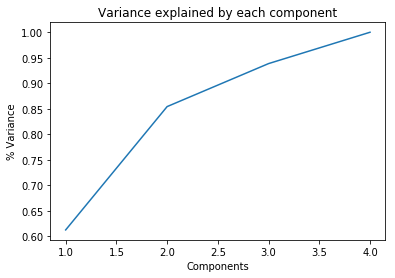

In [247]:
PCA_components(df_990_new) # no components -- that's good

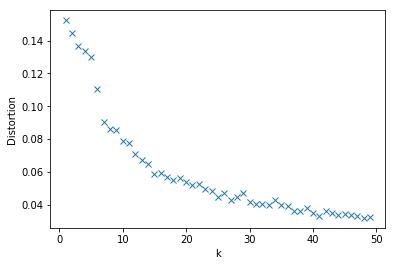

In [248]:
plot_elbow(df_990_new)

In [253]:
model = fit_kmeans(df_990_new, 15)
df_990_new['labels'] = model.labels_
df_990_new.groupby('labels').count()['EIN']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


labels
0     61596
1         1
2         1
3         1
4         1
5       235
6        12
7         1
8         7
9       171
10       34
11        9
12     2095
13       45
14        4
Name: EIN, dtype: int64

### Split 990s by GrossReceiptsAmt

In [254]:
for p in [0.25, 0.5, 0.75, 0.9]:
    print(str(p) + '%: ' + str(df_990['GrossReceiptsAmt'].quantile(p)))

0.25%: -0.03106786651480774
0.5%: -0.030472613456695847
0.75%: -0.027789382552359815
0.9%: -0.014412900752724018


In [303]:
df0 = df_990[df_990['GrossReceiptsAmt'] < -0.03]
df1 = df_990[df_990['GrossReceiptsAmt'] > -0.03]
df1 = df1[df1['GrossReceiptsAmt'] < -0.02]
df2 = df_990[df_990['GrossReceiptsAmt'] >= -0.02]
df2 = df2[df2['GrossReceiptsAmt'] < -0.01]
df3 = df_990[df_990['GrossReceiptsAmt'] >= -0.01]

In [304]:
print(len(df_990) == len(df0) + len(df1) + len(df2) + len(df3))
print(len(df0), len(df1), len(df2), len(df3))

True
37740 18217 2778 5478


[0.45045511 0.57812482 0.68758489 0.77783637 0.85118717 0.90574728
 0.95687044 0.97687557 0.99347472 0.99740052 0.99909897 0.99941995
 0.99966547 0.99979041 0.9998596  0.99992279 0.99997607 1.
 1.        ]


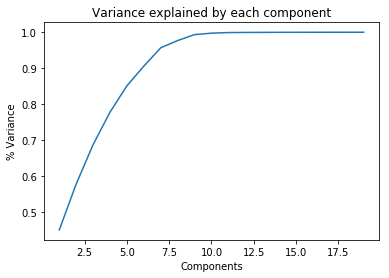

In [269]:
PCA_components(df0) # 3 components
PCA_components(df1) # 3 components
PCA_components(df2) # 4 components
PCA_components(df3) # 7 components

In [305]:
d0_pca = fit_pca(df0, 3)
d1_pca = fit_pca(df1, 3)
d2_pca = fit_pca(df2, 4)
d3_pca = fit_pca(df3, 7)

In [308]:
model = fit_kmeans(d0_pca, 10)
d0_pca['labels'] = model.labels_
d0_pca.groupby('labels').count()['EIN']

labels
0    37377
1        1
2      259
3        1
4        2
5       24
6       64
7        2
8        9
9        1
Name: EIN, dtype: int64

In [309]:
model = fit_kmeans(d1_pca, 10)
d1_pca['labels'] = model.labels_
d1_pca.groupby('labels').count()['EIN']

labels
0    17963
1        1
2        2
3        9
4        8
5        1
6        1
7      202
8       28
9        2
Name: EIN, dtype: int64

In [310]:
model = fit_kmeans(d2_pca, 10)
d2_pca['labels'] = model.labels_
d2_pca.groupby('labels').count()['EIN']

labels
0      79
1       2
2      10
3     305
4    2319
5      28
6       1
7       2
8      29
9       3
Name: EIN, dtype: int64

In [311]:
model = fit_kmeans(d3_pca, 10)
d3_pca['labels'] = model.labels_
d3_pca.groupby('labels').count()['EIN']

labels
0    5322
1       9
2       1
3       1
4       7
5       1
6     116
7       9
8       1
9      11
Name: EIN, dtype: int64